In [32]:
# RNN LSTM Model 

In [33]:
# Required Libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv
from matplotlib import pyplot
from math import sqrt
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dropout, Dense, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import time

In [34]:
# Loading the Temperature Dataset

# Change Directory
os.chdir(r"C:\Users\irfan\Desktop\RWISTest")

#Load Weather and Temperature Data Train
Tempdf = read_csv('Temperature_Train_Deploy.csv', parse_dates = [['Date', 'Time']])
Temp_df = pd.DataFrame(Tempdf)
Temp_df = Temp_df.iloc[::-1]
database = Temp_df

#Load Weather and Temperature Data Test
Tempdf1 = read_csv('Temperature_Test_Paper.csv', parse_dates = [['Date', 'Time']])
Temp_df1 = pd.DataFrame(Tempdf1)
Temp_df1 = Temp_df1.iloc[::-1]
database1 = Temp_df1

In [35]:
# Data Pre-Processing

#Removing null/error data in Train dataset
database = database[database.IR1 != 32]
database = database[database.IR2 != 32]
database = database[database.IR1 != 0]
database = database[database.IR2 != 0]
database = database[database.Temprature != 0]
database = database[database.Probe1 != 0]
database = database[database.Probe2 != 0]

database = database.query('IR1 < 85')
database = database.query('IR2 < 85')
database = database.query('Temprature < 85')
database = database.query('Probe1 < 85')
database = database.query('Probe2 < 85')
database = database.query('IR1 > -10')
database = database.query('IR2 > -10')
database = database.query('Temprature > -10')
database = database.query('Probe1 > -10')
database = database.query('Probe2 > -10')
 
#Removing null/error data in Test dataset
database1 = database1[database1.IR1 != 32]
database1 = database1[database1.IR2 != 32]
database1 = database1[database1.IR1 != 0]
database1 = database1[database1.IR2 != 0]
database1 = database1[database1.Temprature != 0]
database1 = database1[database1.Probe1 != 0]
database1 = database1[database1.Probe2 != 0]

database1 = database1.query('IR1 < 85')
database1 = database1.query('IR2 < 85')
database1 = database1.query('Temprature < 85')
database1 = database1.query('Probe1 < 85')
database1 = database1.query('Probe2 < 85')
database1 = database1.query('IR1 > -10')
database1 = database1.query('IR2 > -10')
database1 = database1.query('Temprature > -10')
database1 = database1.query('Probe1 > -10')
database1 = database1.query('Probe2 > -10')

#IR Smoothing [Filter] -- Train dataset
from astropy.convolution import convolve, Box1DKernel
smoothed_signal_Train = convolve(database.IR1, Box1DKernel(10))
smoothed_signal_Train = pd.DataFrame(smoothed_signal_Train)
smoothed_signal_Train = smoothed_signal_Train.set_index(database.index)
database['IR1'] = smoothed_signal_Train

from astropy.convolution import convolve, Box1DKernel
smoothed_signal_Train1 = convolve(database.IR2, Box1DKernel(10))
smoothed_signal_Train1 = pd.DataFrame(smoothed_signal_Train1)
smoothed_signal_Train1 = smoothed_signal_Train1.set_index(database.index)
database['IR2'] = smoothed_signal_Train1

#IR Smoothing [Filter] -- Test dataset
from astropy.convolution import convolve, Box1DKernel
smoothed_signal_Test = convolve(database1.IR1, Box1DKernel(10))
smoothed_signal_Test = pd.DataFrame(smoothed_signal_Test)
smoothed_signal_Test = smoothed_signal_Test.set_index(database1.index)
database1['IR1'] = smoothed_signal_Test

from astropy.convolution import convolve, Box1DKernel
smoothed_signal_Test1 = convolve(database1.IR2, Box1DKernel(10))
smoothed_signal_Test1 = pd.DataFrame(smoothed_signal_Test1)
smoothed_signal_Test1 = smoothed_signal_Test1.set_index(database1.index)
database1['IR2'] = smoothed_signal_Test1

#Remove last ten data sample due to irregularity of data endpoint arising from the filter function
database = database.iloc[:-10]
database1 = database1.iloc[:-10] 

In [36]:
# Creating empty rows corresponding to missing timestamp 
database['Date_Time'] = pd.to_datetime(database['Date_Time'])
database['Date_Time'] = database['Date_Time'].apply(lambda t: t.replace(minute=0, second=0))
database = database.drop_duplicates(['Date_Time'])
database = database.set_index('Date_Time')
database = database.asfreq('H')

database1['Date_Time'] = pd.to_datetime(database1['Date_Time'])
database1['Date_Time'] = database1['Date_Time'].apply(lambda t: t.replace(minute=0, second=0))
database1 = database1.drop_duplicates(['Date_Time'])
database1 = database1.set_index('Date_Time')
database1 = database1.asfreq('H')

# Remove any consecutively missing data of above k hours - Train dataset
k = 3 #Interpolating values consecutively for more than 3 hours might deviate a lot from the actual possible value
i = database.IR1.isnull()
m = ~(database.groupby(i.ne(i.shift()).cumsum().values).IR1.transform('size').ge(k) & i)
database = database[m]
database = database.drop(columns=['Station ID'])

#Interpolating between two available values to populate the empty rows
database = database.interpolate(method='linear', limit_direction='forward', axis=0)

# Remove any consecutively missing data of above k hours - Train dataset
i = database1.IR1.isnull()
m = ~(database1.groupby(i.ne(i.shift()).cumsum().values).IR1.transform('size').ge(k) & i)
database1 = database1[m]
database1 = database1.drop(columns=['Station ID'])

#Interpolating between two available values to populate the empty rows
database1 = database1.interpolate(method='linear', limit_direction='forward', axis=0)
date = database1.index

In [37]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
# Preparing the train and test dataset for model training
#training part
###################################
# load dataset
values = database.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag data interval ( 1 = 2 minute) 
n_2minutes = 5
n_features = 5
# frame as supervised learning
reframed = series_to_supervised(scaled, n_2minutes, 1)
###################################

###################################
# load dataset
values1 = database1.values
# ensure all data is float
values1 = values1.astype('float32')
# normalize features
scaler1 = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.transform(values1)
# specify the number of lag hours
n_2minutes = 5
n_features = 5
# frame as supervised learning
reframed1 = series_to_supervised(scaled, n_2minutes, 1)
####################################

#Forecast distance
futuredist = 3 # 1 here corresponds to 1 hour                
datalength = n_features * (n_2minutes + 1)

#Creating input and output for model training
train_X = reframed.iloc[:, :-(futuredist*n_features)].values
train_y = reframed.iloc[:, (datalength-n_features+3)].values

train_X_input2 = reframed.iloc[:, (datalength-n_features)].values #Current Ambient Temperature

test_X = reframed1.iloc[:, :-(futuredist*n_features)].values
test_y = reframed1.iloc[:, (datalength-n_features+3)].values

test_X_input2 = reframed1.iloc[:, (datalength-n_features)].values #Current Ambient Temperature

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], (n_2minutes - futuredist +1),  n_features))
test_X = test_X.reshape((test_X.shape[0], (n_2minutes - futuredist +1), n_features))

train_X_input2 = train_X_input2.reshape((train_X_input2.shape[0], 1, 1))
test_X_input2 = test_X_input2.reshape((test_X_input2.shape[0], 1, 1))

In [20]:
# Model Architecture

# Design Network 1
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True)) # Hidden Layer 1
model.add(Dropout(0.25))
model.add(LSTM(25, return_sequences=True)) # Hidden Layer 2
model.add(Dropout(0.25))
model.add(LSTM(25)) # Hidden Layer 3

# Design Network 2
model2 = Sequential()
model2.add(LSTM(50, input_shape=(train_X_input2.shape[1], train_X_input2.shape[2]), return_sequences = True)) # Hidden Layer 1
model2.add(Dropout(0.25))
model2.add(LSTM(25)) # Hidden Layer 2

# Netowrks are Concatenated
Output = Concatenate()([model.output, model2.output])
OutputModel=Dense(10)(Output)

OutputModel=Dense(1)(OutputModel) #Output

# Model Inputs and Output defined
modelz = Model(inputs=[model.input, model2.input], outputs = OutputModel)

# Model feature defined
modelz.compile(loss='mae', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=15, verbose=1, mode='auto',
            restore_best_weights=True)

Restoring model weights from the end of the best epoch.
Epoch 00076: early stopping


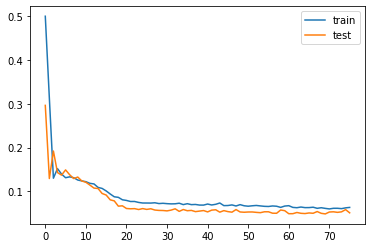

In [21]:
# Model Training and 

history = modelz.fit([train_X, train_X_input2],[train_y], epochs=100, batch_size=256, validation_data=([test_X, test_X_input2], [test_y]),callbacks=[monitor], verbose=0, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
# Forecast Output
yhat = modelz.predict([test_X, test_X_input2])
test_X = test_X.reshape((test_X.shape[0], (n_2minutes-futuredist+1)*n_features))
# invert scaling for forecast
inv_yhat = concatenate((test_X[:, -12:-9], yhat), axis=1)
inv_yhat = concatenate ((inv_yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,3]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -12:-9],test_y),axis=1)
inv_y = concatenate ((inv_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,3]
Actual = inv_y # Ground Truth - Road Surface Temperature IR1
RRN = inv_yhat # Predicted IR1 - Road Surface Temperature IR1

In [40]:
# calculate RMSE
MAE = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f degree Fahrenheit' % MAE)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
r2 = r2_score(inv_y, inv_yhat)
print('Test R2: %.3f' % r2)

#from keras.models import load_model
# Creates a HDF5 file 'my_model.h5'
modelz.save('LSTM_MLDeployment.h5')
# save the scaler
from pickle import dump
dump(scaler, open('scaler.pkl', 'wb'))
# Save the weights
modelz.save_weights('LSTMmodel_weightshourly.h5')

# Save the model architecture
with open('LSTMmodel_architecturehourly.json', 'w') as f:
    f.write(modelz.to_json())
    

Test MAE: 3.304 degree Fahrenheit
Test RMSE: 4.346
Test R2: 0.895


In [49]:
#date = date[5:] # We have to delete first 5 date as the dataset when shifted by 5 loses the first 5 sample
dataframe = pd.DataFrame({'Date_Time' : date, 'Actual_IR1' : Actual, 'Predicted_IR1' : RRN}, columns= ['Date_Time', 'Actual_IR1', 'Predicted_IR1'])
dataframe

,Date_Time,Actual_IR1,Predicted_IR1
0,2020-01-24 19:00:00,44.213001,45.409702
1,2020-01-24 20:00:00,41.090000,41.632565
2,2020-01-24 21:00:00,39.803001,40.914051
3,2020-01-24 22:00:00,38.029999,40.043247
4,2020-01-24 23:00:00,36.536003,38.635841
...,...,...,...
384,2020-02-09 19:00:00,56.561001,53.837242
385,2020-02-09 20:00:00,53.555000,50.962597
386,2020-02-09 21:00:00,50.324001,48.393322
387,2020-02-09 22:00:00,46.759998,45.264229


[Text(0, 0.5, 'Temperature Fahrenheit'), Text(0.5, 0, 'date')]

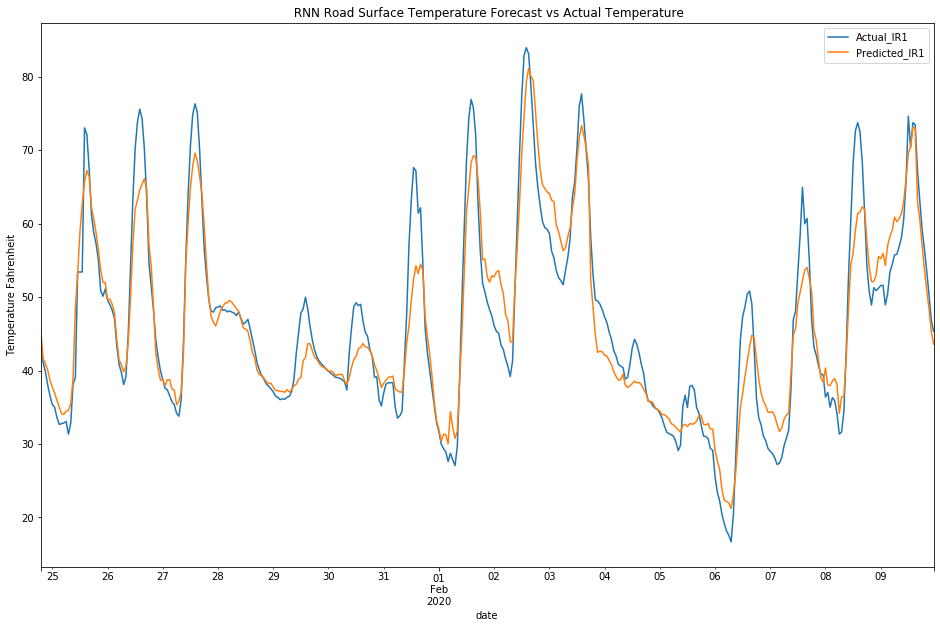

In [51]:
pred = pd.concat([dataframe.Actual_IR1,dataframe.Predicted_IR1], axis=1)
pred = pred.set_index(dataframe.Date_Time)

title = ' RNN Road Surface Temperature Forecast vs Actual Temperature'
xlabel='date'
ylabel='Temperature Fahrenheit'

ax= pred.plot(figsize=(16,10), title = title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)